In [1]:
import sys
import os
import gc
import collections

import cartopy.crs as ccrs
import cartopy
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams, cycler
from matplotlib import animation, rc
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import numpy as np
import xarray as xr
import geopandas as gpd
import rioxarray
from xeofs.xarray import EOF, Rotator, ROCK_PCA

import statsmodels.api as sm
import scipy
from sklearn.metrics import mean_squared_error
from itertools import product
import pyproj
from shapely.geometry import mapping
from xarrayutils.utils import linear_trend, xr_linregress
import pandas as pd
import cmocean

# NOTE: Local xeofs to be submitted as pull-request (addition of xeofs.model.reconstruct_randomized_X method)

# Define local plotting parameters
#sns.set_theme(style="whitegrid")
#sns.set_theme(style="ticks")
sns.set_theme(style="white")
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
plt.rcParams.update({'font.size': 15})
plt.rc('font', family='sans-serif') 
plt.rc('font', serif='Helvetica Neue')
plt.rc('text', usetex=True)


# To update following with relative repository paths once data and code is up on Zenodo
# Current version uses the project template on Github.

# Define project repo path
inDirName = '/Users/smurugan9/research/aislens/aislens_emulation/'

# DATA FILE PATHS
# Data containing regridded flux and SSH for 150 years
regriddedFluxSSH_filepath = 'data/interim/RegriddedFluxSSH.nc'
# File contains all defined ice shelves
iceShelvesShape_filepath = 'data/interim/iceShelves.geojson'

# Relative directory paths for Data and Figures
figures_folderpath = 'reports/figures/'
interim_data_folder = 'data/interim/'
processed_data_folder = 'data/processed/'
flux_dedrafted_data_path = 'dedrafted_flux_IMBIE/'
randomized_realizations_path = 'randomized_realizations/'
flux_dedrafted_iceshelves_data_path = 'iceshelves_dedrafted_flux/'
reconstructions_neofs_path = 'reconstructions_neofs/'
cise_file_path = 'cise_data/'
std_file_path = 'standardized_rec_data/'


pca_1 = '1_pca/'
pca_2 = '2_pca_normalized/'
pca_3 = '3_pca_normalized_nmodes/'
pca_4 = '4_lowpass_ pca_normalized/'


# Catchment boundary masks for Antarctica, taken from ice shelf definitions in MPAS-Dev/geometric-features
# Source: https://github.com/MPAS-Dev/geometric_features/tree/main/geometric_data
# These have been combined into one file with 133 defined regions (polygons and multipolygons), 
# readable via the Geopandas package

# Read geoJSON region feature file as GeoDataFrame
iceshelvesmask = gpd.read_file(inDirName + iceShelvesShape_filepath)

# Convert to south polar stereographic projection
#icems = iceshelvesmask.to_crs({'init': 'epsg:3031'}); # This has been deprecated
icems = iceshelvesmask.to_crs('epsg:3031');
crs = ccrs.SouthPolarStereo();

# Original forcing data: raw MPAS-O output, mapped to the 10km resolution grid
# flux is freshwater flux
# ssh is sea surface height, used here as a proxy for ice draft / depth.

# ssh is used to plot the scatterplot of flux vs. draft for different ice shelves 
# and as input for the linear regression used in "dedrafting" the dataset

regridded_data = xr.open_dataset(inDirName+regriddedFluxSSH_filepath)
flux = regridded_data.timeMonthly_avg_landIceFreshwaterFlux
ssh = regridded_data.timeMonthly_avg_ssh

# Pre-processed data: detrended, deseasonalized, dedrafted
flux_clean = xr.open_dataset(inDirName+interim_data_folder+'flux_clean')
flux_clean = flux_clean.timeMonthly_avg_landIceFreshwaterFlux

# Dedrafted flux
flux_dedrafted = xr.open_dataset(inDirName+
                                 interim_data_folder+
                                 flux_dedrafted_iceshelves_data_path+'iceshelves_dedrafted_total.nc')
flux_dedrafted = flux_dedrafted.timeMonthly_avg_landIceFreshwaterFlux

# Flux datapoints extracted for individual ice shelves, used for the scatter plots
# catchments_scatter = np.load(inDirName+interim_data_folder+"catchments_scatter.npy")
# catchments_scatter_xr = xr.DataArray(catchments_scatter,dims={'basin','x','y'})

# Add reconstructed datasets - seed random (can also be set as random_state in PCA implementation within xeofs)

/var/folders/6b/9ftjhcg16g19w33zvk7zd7mm0131yc/T/ipykernel_6861/2641425726.py:17: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


In [3]:
alph = 5
print(pca_1+'indirname{}'.format(alph))

1_pca/indirname5


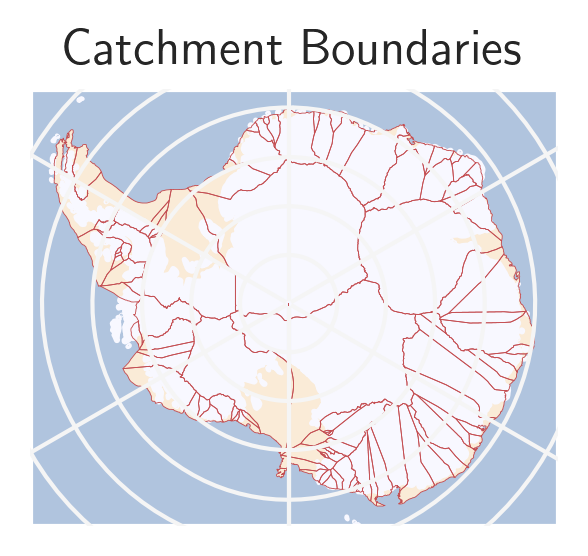

In [13]:
# Plot boundaries

plt.figure(figsize=(5,5))
ax1 = plt.subplot(121,projection=ccrs.SouthPolarStereo())
ax1.gridlines(color='whitesmoke',zorder=4)
icems[34:133].plot(ax=ax1,color='antiquewhite', linewidth=0,zorder=1)
icems[34:133].boundary.plot(ax=ax1,color='r', linewidth=0.2,zorder=3)
#icems[34:133].boundary.plot(ax=ax1,linewidth=0.25,color='lightgray',zorder=4)
#ax1.coastlines(resolution='10m', zorder=6,linewidth=0.75)
ax1.patch.set_facecolor(color='lightsteelblue')
#ax1.add_feature(cartopy.feature.LAND, color='ghostwhite')
ax1.add_feature(cartopy.feature.LAND, color='ghostwhite', zorder=2)
plt.title('Catchment Boundaries');

In [29]:
flux_clean_tmean = flux_clean.mean('time')
flux_clean_tstd = flux_clean.std('time')

In [48]:
pca_pcs = xr.open_dataset(inDirName+processed_data_folder+pca_1+"pcs.nc")
pca_pcs = pca_pcs.PCs

In [2]:
## Input generated dataset files
# This section presents a sample case of 1 generated realization
# Customize this section as necessary
spcarec0 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+std_file_path+"spca_a1/spca_a1_REC0.nc")

eofs = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+std_file_path+"spca_a01/eofs.nc")
pcs = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+std_file_path+"spca_a01/pcs.nc")
pcs = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+std_file_path+"spca_a1/sparse_pcs.nc")

eofs = eofs.EOFs
pcs = pcs.PCs
nmodes = 1500

In [6]:
scipy.stats.shapiro(pcs[:,0])

ShapiroResult(statistic=0.7344030141830444, pvalue=1.0089348943138683e-43)

In [7]:
def statistic(x):
    # Get only the `shapiro` statistic; ignore its p-value
    return stats.shapiro(x).statistic

ref = stats.monte_carlo_test(x, stats.norm.rvs, statistic, alternative='less')
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8, 5))
bins = np.linspace(0.65, 1, 50)
def plot(ax):  # we'll re-use this
    ax.hist(ref.null_distribution, density=True, bins=bins)
    ax.set_title("Shapiro-Wilk Test Null Distribution \n"
                 "(Monte Carlo Approximation, 11 Observations)")
    ax.set_xlabel("statistic")
    ax.set_ylabel("probability density")
plot(ax)
plt.show()

NameError: name 'stats' is not defined

In [77]:
for i in range(5):
    corrfac = np.corrcoef(pcs[:,i], pcs[:,i+1])
    #corrfac = np.corrcoef(pcs[:,0], pcs[:,1])
    print(corrfac)

[[ 1.        -0.0300569]
 [-0.0300569  1.       ]]
[[1.         0.13022884]
 [0.13022884 1.        ]]
[[1.         0.04545511]
 [0.04545511 1.        ]]
[[ 1.         -0.12722325]
 [-0.12722325  1.        ]]
[[ 1.         -0.07992487]
 [-0.07992487  1.        ]]


In [94]:
import pandas as pd
import numpy as np

rs = pcs
df = pd.DataFrame(pcs[:,0:150])
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

In [95]:
xeofs

<xarray.Dataset>
Dimensions:                        (time: 1500, x: 601, y: 601)
Coordinates:
  * time                           (time) datetime64[ns] 2026-01-31 ... 2150-...
  * x                              (x) float64 -3e+06 -2.99e+06 ... 3e+06
  * y                              (y) float64 -3e+06 -2.99e+06 ... 3e+06
    lat                            (y, x) float64 ...
    lon                            (y, x) float64 ...
    spatial_ref                    int64 ...
Data variables:
    __xarray_dataarray_variable__  (time, x, y) float64 ...

In [84]:
corr - np.diag(corr)

0         1         2         3         4         5         6   \
0   0.000000 -1.030057 -1.044272 -1.013565 -1.175880 -0.868420 -0.909143   
1  -1.030057  0.000000 -0.869771 -0.938929 -0.924855 -1.060316 -1.006449   
2  -1.044272 -0.869771  0.000000 -0.954545 -1.102144 -1.103692 -1.034474   
3  -1.013565 -0.938929 -0.954545  0.000000 -1.127223 -1.048839 -0.946586   
4  -1.175880 -0.924855 -1.102144 -1.127223  0.000000 -1.079925 -0.990212   
5  -0.868420 -1.060316 -1.103692 -1.048839 -1.079925  0.000000 -0.941416   
6  -0.909143 -1.006449 -1.034474 -0.946586 -0.990212 -0.941416  0.000000   
7  -0.920420 -1.052052 -0.996317 -0.945184 -1.135371 -1.001219 -0.946017   
8  -0.880170 -1.069557 -0.942911 -1.078816 -1.039241 -0.963611 -1.030153   
9  -1.040484 -0.981912 -1.112857 -0.897433 -1.054952 -0.860741 -0.948812   
10 -1.064999 -0.933861 -0.881062 -1.097395 -0.941490 -0.922090 -0.966156   
11 -1.398490 -0.949254 -1.053130 -1.026954 -0.837242 -1.026087 -1.009435   
12 -1.023146 -0.934853 -1.006899 -0.923119 -0.955104 -0.832990 -0.977977   
13 -0.920469 -1.117941 -0.963927 -0.970809 -1.212423 -0.978604 -0.901048   
14 -0.934910 -1.017486 -1.120493 -1.026603 -0.234114 -1.044245 -0.916819   
15 -1.025941 -0.763472 -0.967147 -1.059883 -1.006488 -1.000574 -1.025176   
16 -1.046606 -0.954856 -0.993815 -0.925329 -0.991608 -0.950136 -0.988090   
17 -0.890312 -1.031408 -0.919117 -1.032297 -1.026125 -1.022101 -1.074882   
18 -0.980330 -1.039432 -1.045425 -1.025476 -0.994603 -0.560683 -1.012506   
19 -0.998354 -0.914521 -0.983464 -1.030741 -1.027158 -0.593036 -1.085549   
20 -0.966860 -1.087297 -1.089463 -0.910609 -0.975641 -1.016086 -0.884079   
21 -0.980888 -0.792121 -0.923862 -1.098122 -0.940668 -0.857491 -0.905811   
22 -0.931067 -1.173111 -0.994790 -1.151358 -1.044959 -0.957049 -0.986382   
23 -0.998606 -0.852960 -0.991421 -0.984891 -0.946214 -0.596945 -1.084084   
24 -0.904311 -1.035866 -0.935450 -1.043929 -0.893815 -0.977315 -1.067005   
25 -0.911088 -0.763363 -0.701243 -1.041206 -1.033032 -1.028886 -0.917469   
26 -0.907684 -0.967131 -0.985393 -0.838823 -1.112752 -1.085812 -1.077677   
27 -0.870232 -1.024525 -1.006138 -1.056480 -1.057602 -0.955235 -0.985767   
28 -0.886007 -1.080075 -0.942856 -1.080168 -1.042773 -0.970214 -1.022251   
29 -0.833434 -0.586269 -0.981974 -0.930453 -0.883692 -0.854076 -0.870941   
30 -0.964538 -0.810137 -0.981065 -0.895626 -1.094289 -1.022094 -1.058844   
31 -0.879352 -0.940361 -1.031932 -0.844693 -1.099572 -1.135006 -1.045944   
32 -0.987400 -1.077628 -1.043380 -0.908201 -1.292227 -0.996777 -0.811355   
33 -0.826626 -0.865251 -1.092940 -1.006511 -0.914783 -0.812514 -0.965630   
34 -1.009102 -1.018877 -1.056141 -0.991941 -0.935460 -0.659779 -1.001074   
35 -0.946426 -0.977214 -1.029571 -0.912825 -1.042007 -1.055692 -0.958226   
36 -1.034444 -1.017253 -0.966086 -0.921664 -1.107321 -0.981017 -1.022859   
37 -0.965530 -1.041280 -0.972713 -0.851082 -1.022478 -0.901362 -0.980359   
38 -0.893478 -0.663070 -1.051058 -0.980882 -1.046690 -0.792331 -0.960572   
39 -0.877697 -0.713178 -1.017586 -1.045723 -0.984877 -0.902608 -0.957421   
40 -1.042633 -0.835646 -0.869297 -1.078171 -0.972579 -1.106811 -1.074513   
41 -0.952077 -0.927026 -0.992320 -1.043325 -1.094890 -1.002707 -1.086382   
42 -1.006427 -0.983485 -1.057213 -1.072747 -0.949128 -1.082557 -0.822511   
43 -1.150322 -1.052096 -1.082119 -0.699443 -0.952480 -1.028942 -0.987126   
44 -1.000051 -0.698958 -1.030279 -0.986403 -1.055136 -0.826686 -1.052811   
45 -1.008164 -0.854900 -0.980769 -0.987755 -0.972095 -0.693129 -1.095982   
46 -0.976327 -1.057315 -1.005604 -1.014815 -1.210055 -0.979262 -0.820151   
47 -1.027876 -0.962443 -1.011561 -1.027647 -1.078453 -0.920206 -0.933856   
48 -0.842566 -1.041043 -0.919418 -1.009037 -1.132693 -0.992995 -1.011387   
49 -0.914584 -0.990663 -0.946214 -0.948894 -1.078210 -0.964016 -0.944784   

          7         8         9   ...        40        41        42        43  \
0  -0.920420 -0.880170 -1.040484  ... -1.042633 -0.9

In [80]:
sparse_pca(spcarec0)
possibly admit

/Users/smurugan9/opt/anaconda3/envs/aislens/lib/python3.10/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)


0    -0.398490
1    -0.173111
2    -0.120493
3    -0.151358
4    -0.292227
5    -0.135006
6    -0.095982
7    -0.135371
8    -0.157377
9    -0.112857
10   -0.108234
11   -0.398490
12   -0.082519
13   -0.212423
14   -0.120493
15   -0.077731
16   -0.076575
17   -0.198492
18   -0.147234
19   -0.110750
20   -0.106987
21   -0.130263
22   -0.177999
23   -0.099734
24   -0.078798
25   -0.157964
26   -0.183866
27   -0.099104
28   -0.145141
29   -0.198492
30   -0.113729
31   -0.181201
32   -0.292227
33   -0.116833
34   -0.162858
35   -0.106690
36   -0.107321
37   -0.072027
38   -0.100477
39   -0.078808
40   -0.106811
41   -0.175814
42   -0.110750
43   -0.157964
44   -0.158327
45   -0.095982
46   -0.210055
47   -0.107221
48   -0.153829
49   -0.097028
dtype: float64

In [70]:
rs = pcs
df = pd.DataFrame(pca_pcs[:,0:25])
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

In [63]:
pcs[:,0:5]

<xarray.DataArray 'PCs' (time: 1500, mode: 5)>
[7500 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 2026-01-31 2026-02-28 ... 2150-12-31
  * mode     (mode) int64 1 2 3 4 5

In [4]:
np.random.seed(0)

n_realizations = 5
t_length = pcs.shape[0]

# Define random number generator 
#rng = np.random.default_rng(2021)
#random_phases = np.exp(np.random.default_rng(2023).uniform(0,2*np.pi,int(len(fl)/2+1))*1.0j) in line 26

# xeofs_pcs[:,i] when using PCA outputs
new_fl = np.empty((n_realizations,pcs.shape[0],pcs.shape[1]))

# Time limits for plotting
t1 = 0
tf = int(t_length/2)

for i in range(n_realizations):
    for m in range(nmodes):
        fl = pcs[:,m] # fluxpcs[:,i] when using PCA outputs
        fl_fourier = np.fft.rfft(fl)
        #random_phases = np.exp(np.random.uniform(0,2*np.pi,int(len(fl)/2+1))*1.0j)
        #random_phases = np.exp(np.random.default_rng(2023).uniform(0,2*np.pi,int(len(fl)/2+1))*1.0j)
        random_phases = np.exp(np.random.uniform(0,2*np.pi,int(len(fl)/2+1))*1.0j)
        fl_fourier_new = fl_fourier*random_phases
        new_fl[i,:,m] = np.fft.irfft(fl_fourier_new)
    print('calculated ifft for realization {}, all modes'.format(i))

calculated ifft for realization 0, all modes
calculated ifft for realization 1, all modes
calculated ifft for realization 2, all modes
calculated ifft for realization 3, all modes
calculated ifft for realization 4, all modes


In [ ]:
i = 2
new_fl_xr = xr.DataArray(new_fl[i], dims=pcs.dims, coords = pcs.coords, attrs = pcs.attrs)
sparse_mini_rand = new_fl_xr @ eofs.T
sparse_mini_rand = sparse_mini_rand.transpose("time","y","x")
sparse_mini_rand = (sparse_mini_rand*flux_clean_tstd)+flux_clean_tmean
sparse_mini_rand.to_netcdf(inDirName+interim_data_folder+cise_file_path+std_file_path+"spca_a01/spca_a01_REC{}.nc".format(i))
print("Created randomized realization...{}".format(i))

In [35]:
sparse_mini_rand = (sparse_mini_rand*flux_clean_tstd)+flux_clean_tmean
sparse_mini_rand.to_netcdf(inDirName+interim_data_folder+cise_file_path+std_file_path+"spca_a01/spca_a01_REC{}.nc".format(i))
print("Created randomized realization...{}".format(i))

RuntimeError: NetCDF: HDF error

In [33]:
sparse_mini_rand.to_numpy(inDirName+interim_data_folder+cise_file_path+std_file_path+"spca_a01/spca_a01_REC{}.nc".format(i))

TypeError: DataArray.to_numpy() takes 1 positional argument but 2 were given

In [34]:
from netCDF4 import Dataset
import h5py


In [29]:
spca_a01 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+std_file_path+"spca_a01/spca_a01_REC0.nc")
spca_a01 = spca_a01.__xarray_dataarray_variable__

#spca_a1 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+std_file_path+"spca_a1/spca_a1_REC0.nc")
#spca_a1 = spca_a1.__xarray_dataarray_variable__

In [30]:
spcagen0 = spca_a01

In [24]:
spcagen0

<xarray.DataArray '__xarray_dataarray_variable__' (time: 1500, y: 601, x: 601)>
[541801500 values with dtype=float64]
Coordinates:
  * time         (time) datetime64[ns] 2026-01-31 2026-02-28 ... 2150-12-31
  * x            (x) float64 -3e+06 -2.99e+06 -2.98e+06 ... 2.99e+06 3e+06
  * y            (y) float64 -3e+06 -2.99e+06 -2.98e+06 ... 2.99e+06 3e+06
    lat          (y, x) float64 ...
    lon          (y, x) float64 ...
    spatial_ref  int64 ...

In [6]:
flux_clean_ts = flux_clean.sum(['y','x'])
spca_a01_ts = spca_a01.sum(['y','x'])

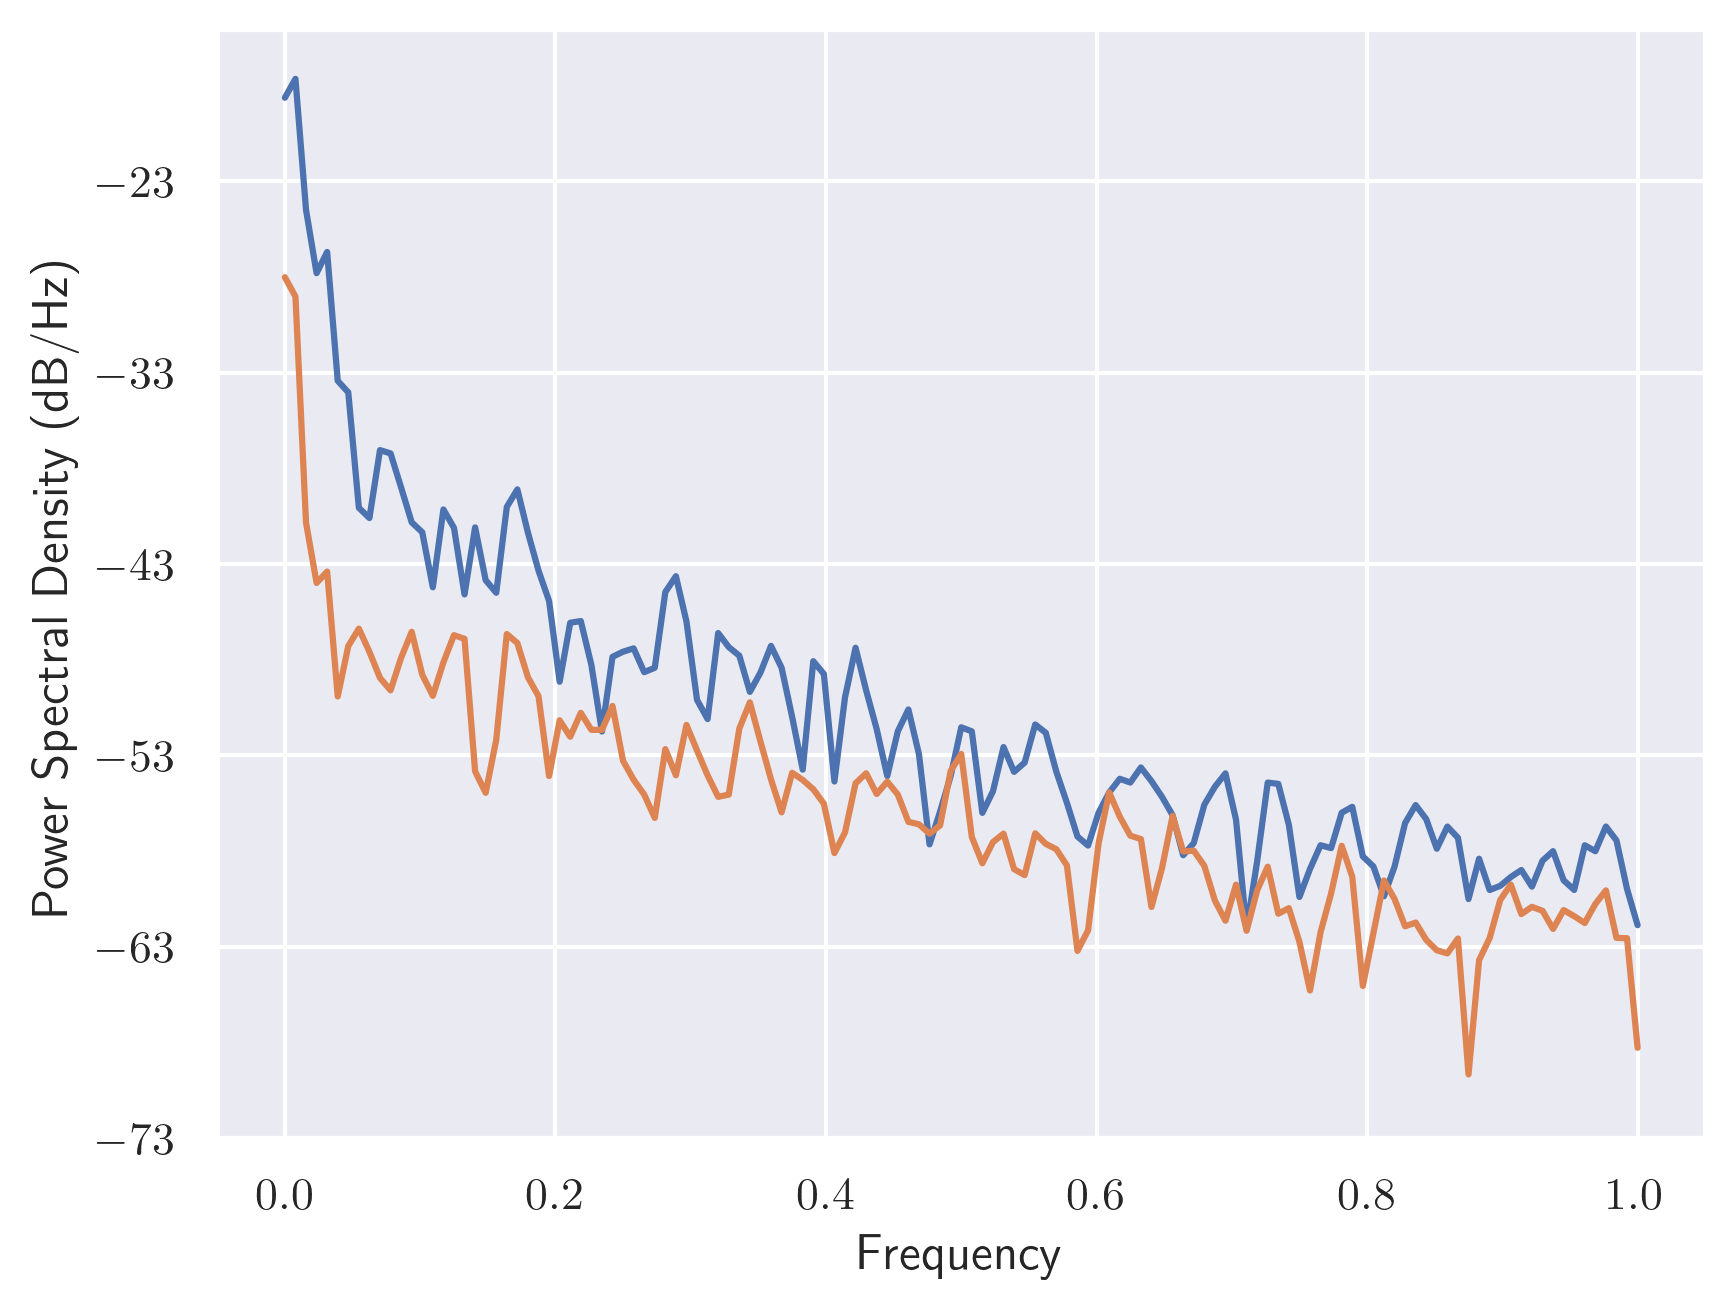

In [7]:
plt.psd(flux_clean_ts);
plt.psd(spca_a01_ts);

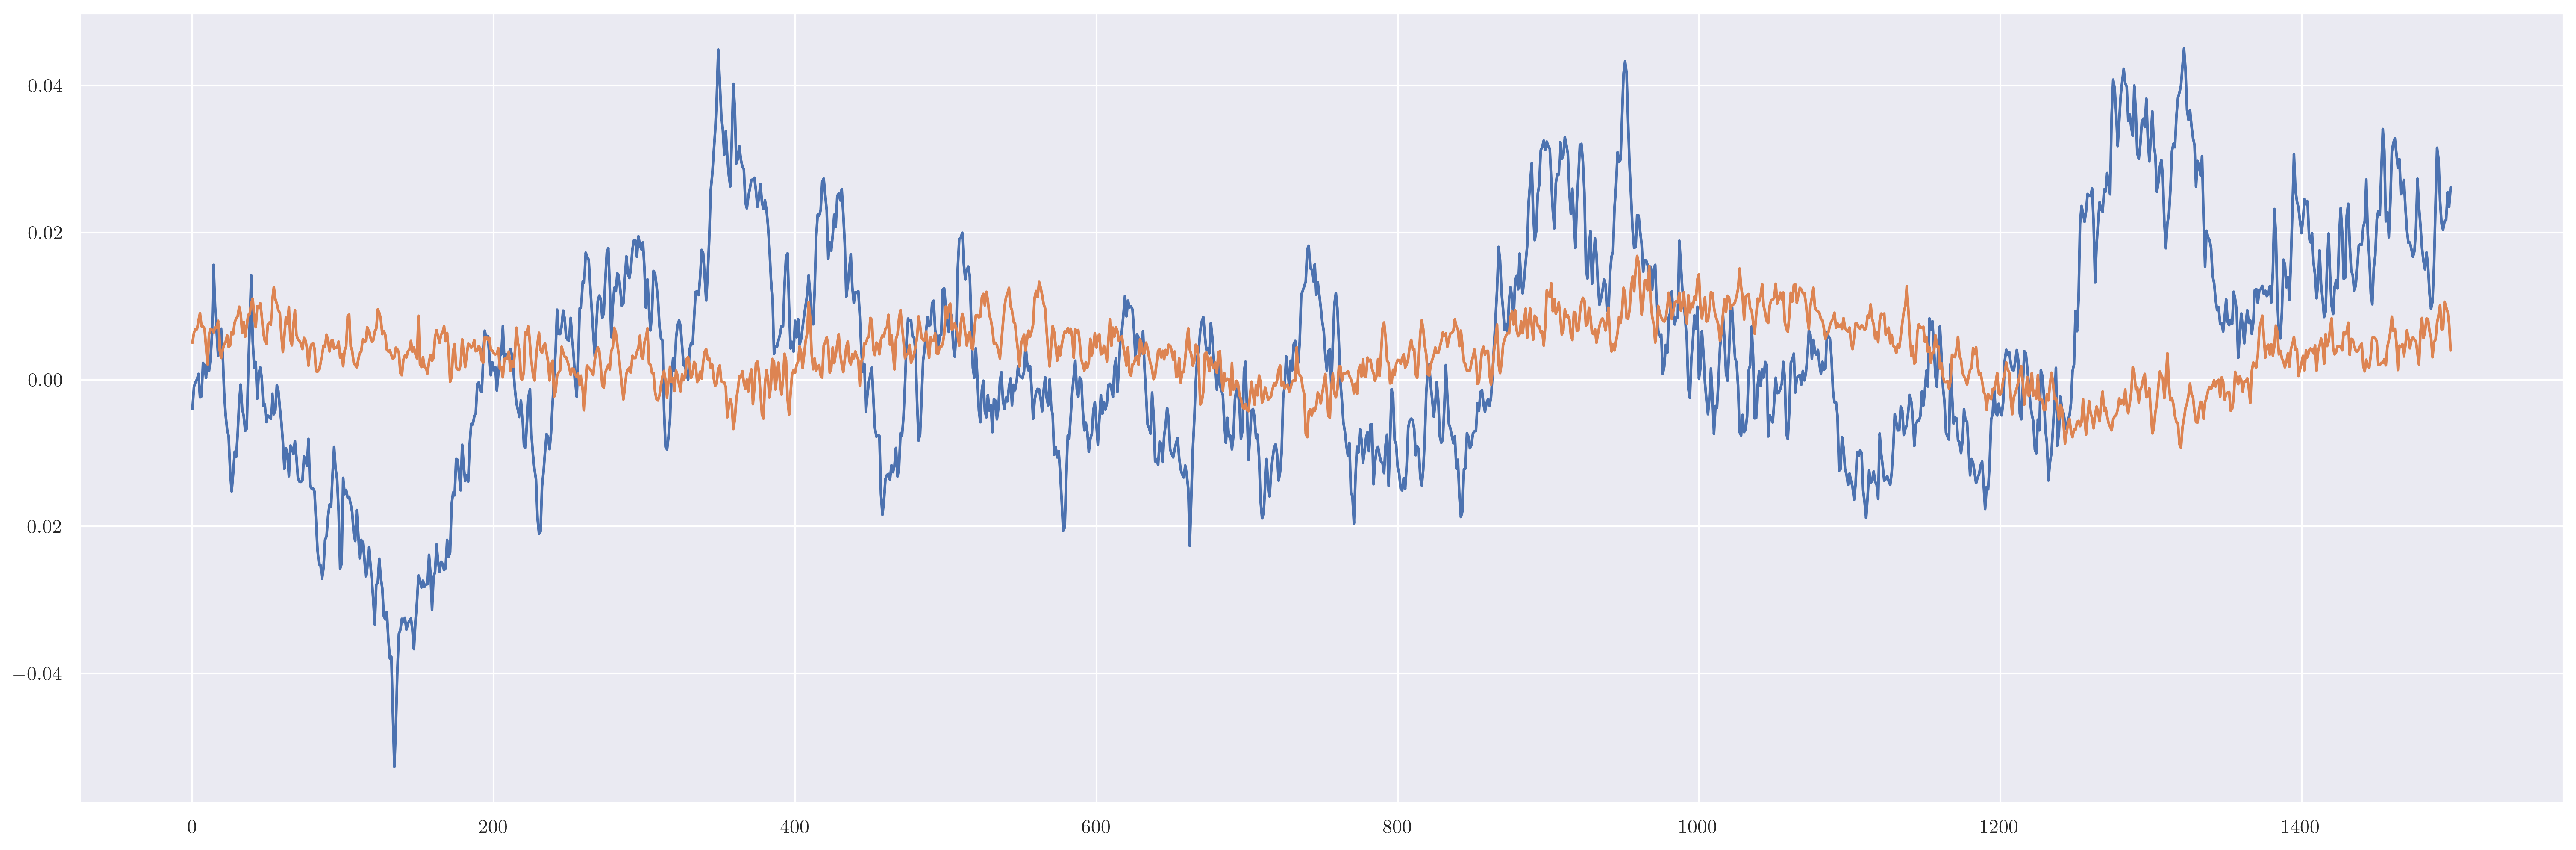

In [8]:
plt.figure(figsize=(25,8))
plt.plot(flux_clean_ts);
plt.plot(spca_a01_ts);

In [10]:
#modified to not return f - in calculation of RMSE, only Px required
def psd_calc_grid(data,y,x):
    f, Px = scipy.signal.welch(data[:,y,x])
    return Px

def time_series(clipped_data):
    clipped_ts = clipped_data.sum(['y','x'])
    return clipped_ts

# Reconstruct flux dataset using phase randomized PCs
# This section is to be called iteratively for ensemble runs with multiple realizations
# This method also takes 'modes' as a parameter: 
# which is used to reconstruct dataset with different number of selected modes

def generate_data(n_realization,mode,mode_skip):
    flux_reconstr = model.reconstruct_randomized_X(new_fl[n_realization],slice(1,mode,mode_skip))
    #flux_reconstr = model.reconstruct_randomized_sparse_X(new_fl[n_realization],slice(1,mode,mode_skip))
    #flux_reconstr = model.reconstruct_X() #(new_fl[n_realization],slice(1,mode,mode_skip))
    #flux_reconstr = flux_reconstr.dropna('time',how='all')
    #flux_reconstr = flux_reconstr.dropna('y',how='all')
    #flux_reconstr = flux_reconstr.dropna('x',how='all')
    #flux_reconstr = flux_reconstr.drop("month")
    return flux_reconstr

def generate_noise(n_realization,mode,mode_skip):
#flux_reconstr_noise = model.reconstruct_randomized_X(new_fl_high[n_realization],slice(1,mode,mode_skip))
    #flux_reconstr = flux_reconstr.dropna('time',how='all')
    #flux_reconstr = flux_reconstr.dropna('y',how='all')
    #flux_reconstr = flux_reconstr.dropna('x',how='all')
    #flux_reconstr = flux_reconstr.drop("month")
    return flux_reconstr_noise


def clip_data(total_data, basin):
    clipped_data = total_data.rio.clip(icems.loc[[basin],'geometry'].apply(mapping))
    #clipped_data = clipped_data.dropna('time',how='all')
    #clipped_data = clipped_data.dropna('y',how='all')
    #clipped_data = clipped_data.dropna('x',how='all')
    #clipped_data = clipped_data.drop("month")
    return clipped_data

ValueError: Unsupported key-type <class 'tuple'>

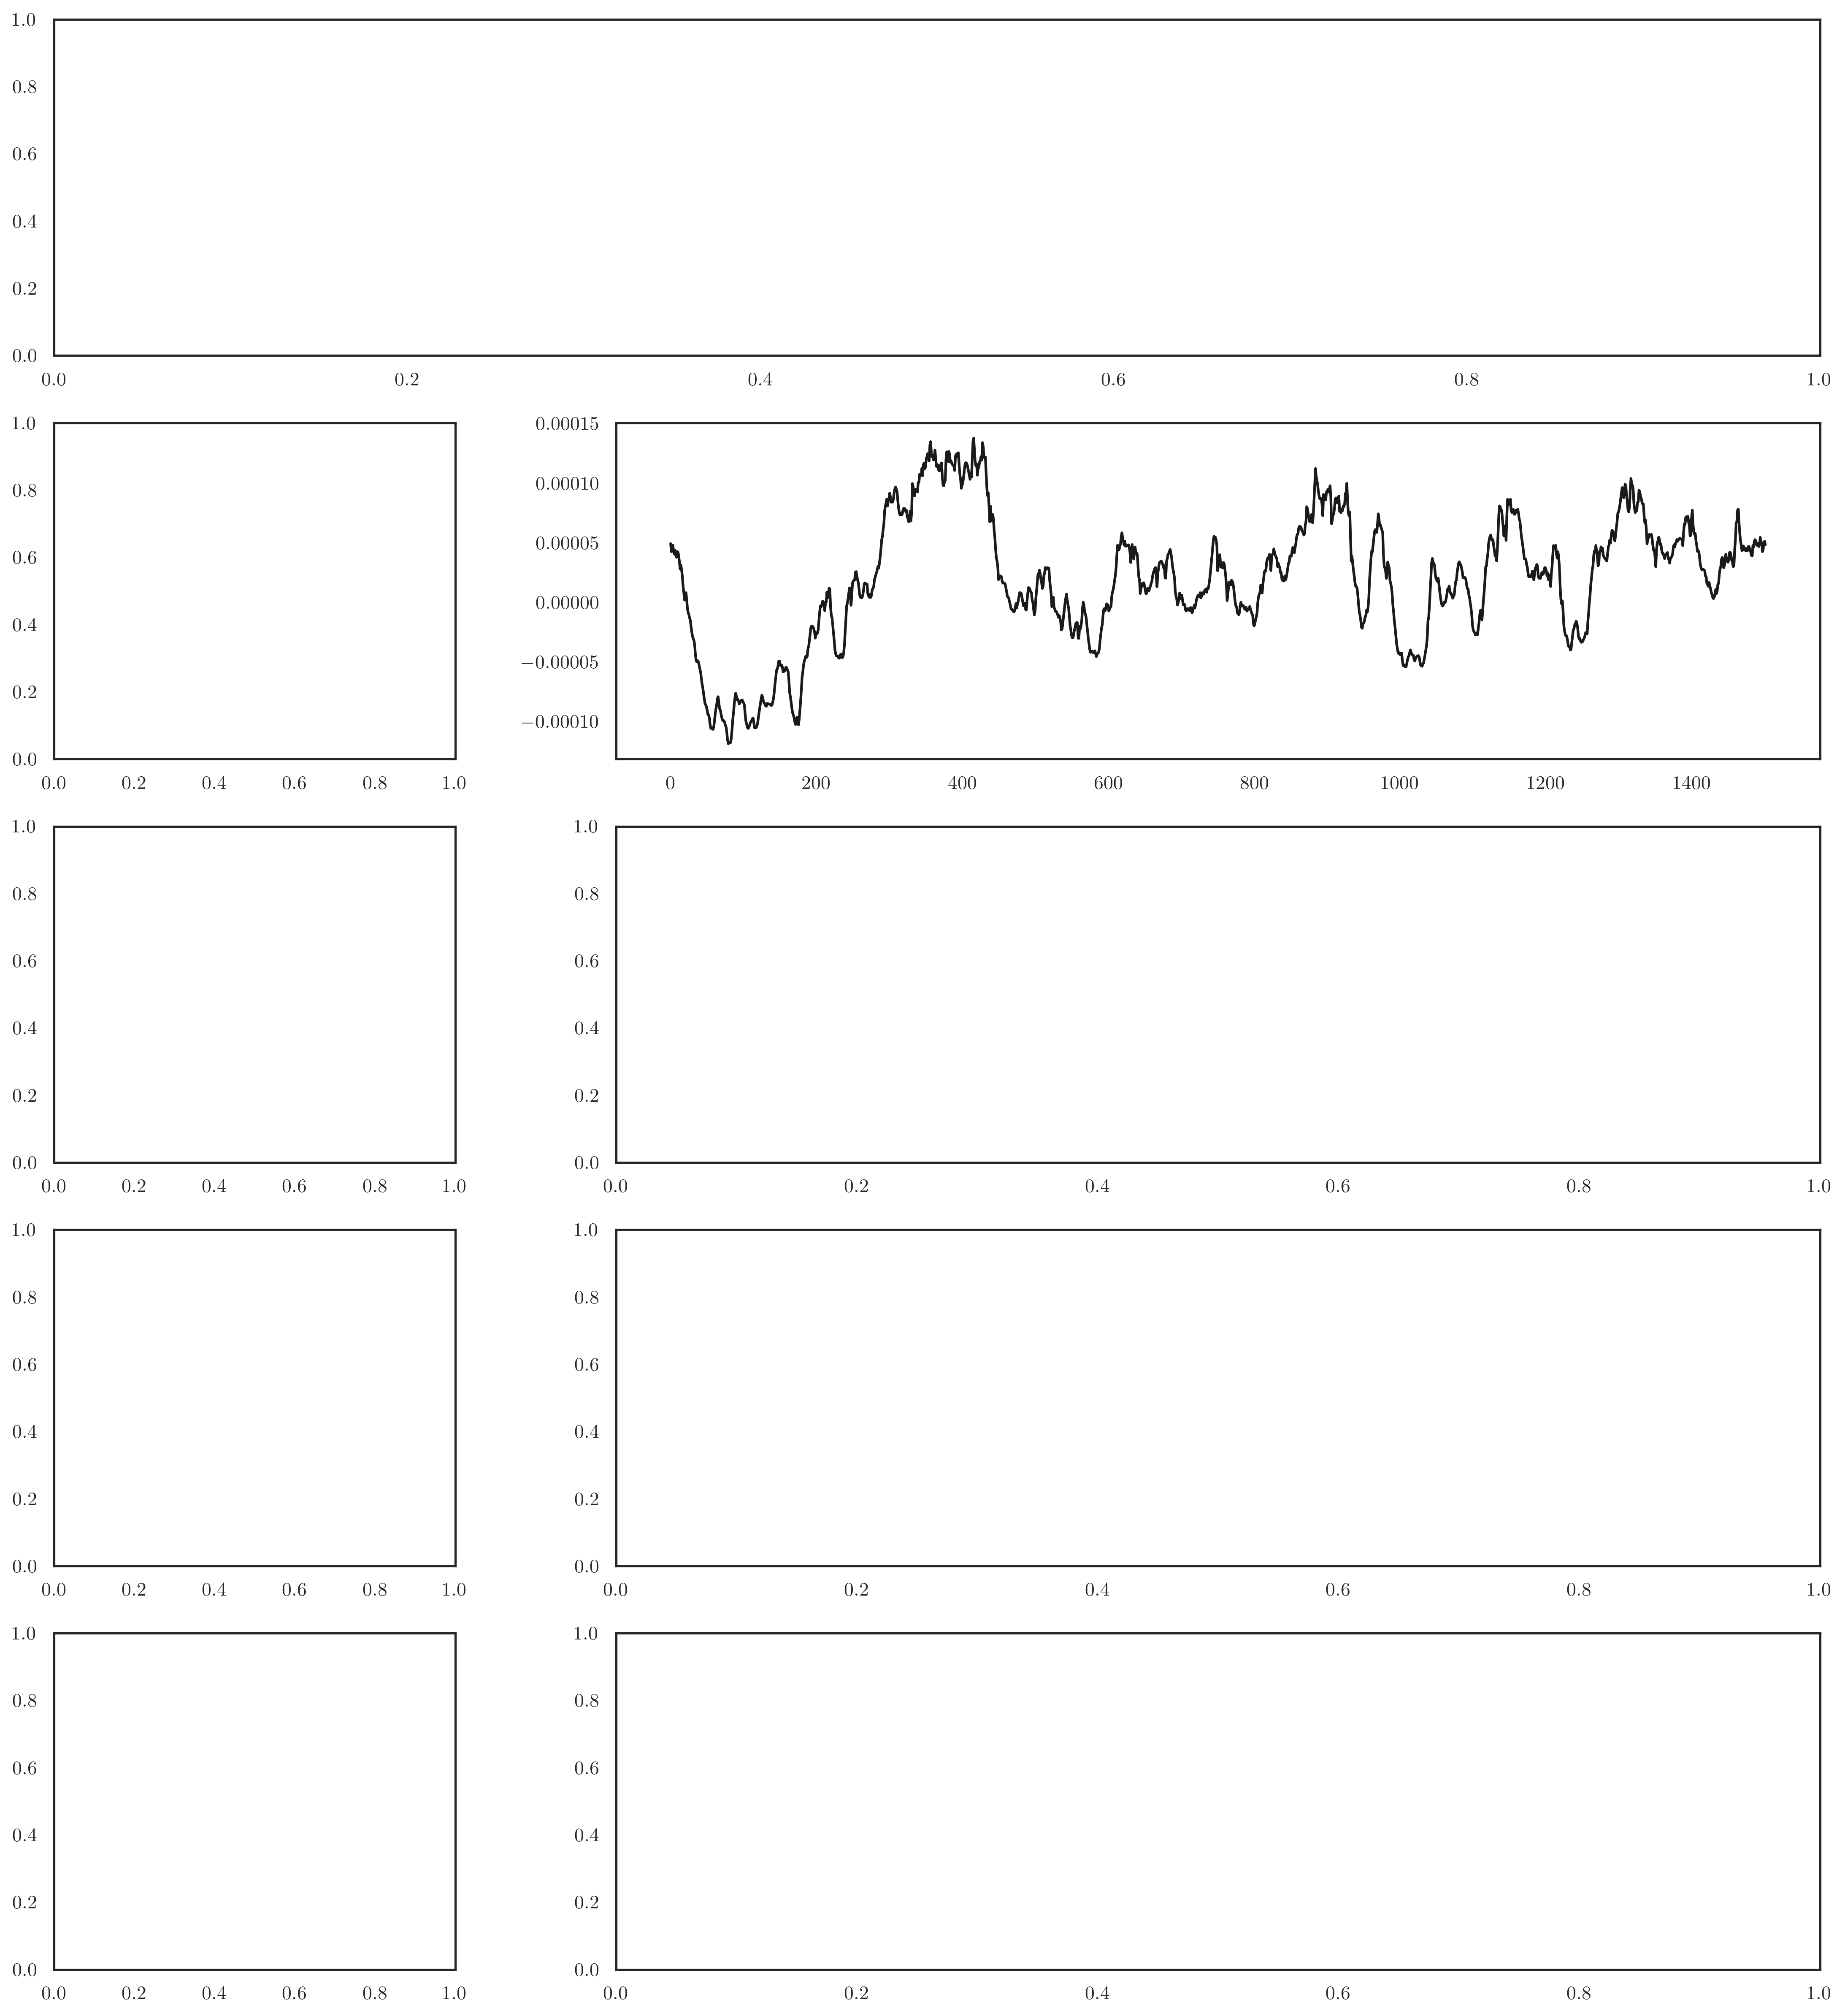

In [32]:
#catchments = np.array([1,27,28,61,70,83,94,71,22])
#basins = catchments+33

#basins = [34, 55, 60, 61, 94, 103]
#basins = [55,94]
#basins = [34, 60]
#grid_points = np.array(([85,105], [115,45], [4,45],[21,56], [11,10], [34,95]))
#grid_points = np.array(([115,45],[11,10]))
#grid_points = np.array(([85,105],[4,45]))

basins = [34,94,60,55,94]
# Choose grid points based on dataset indices. Can find these using data.x and data.y dimension arrays.
# Locations here have been selected based on performance of model simulation data at these points, 
# given also the variance between them (in terms of temporal scale of variability)
grid_points = np.array(([85,105], [11,10],[15,44], [100,40]))

#basins = np.array([34, 60, 94, 55])
# [2,3,4,5] = [Antarctica, Peninsula, West Antarctica, East Antarctica]

n_basins = len(basins)
oc = 'k'
pcac = '#D55E00'#'#FC8D62'
spcac = 'steelblue'#'#0072B2' #'#CC79A7'

lwbg = 0.1
lworig = 1.5
lwgen = 0.8

sns.set_theme(style="white")
fig=plt.figure(figsize=(18,4*n_basins))
gs = GridSpec(n_basins, 2, width_ratios=[1,3])
axtop = fig.add_subplot(gs[0, :])
ax0 = [fig.add_subplot(gs[i, 0]) for i in range(1,n_basins)]
ax1 = [fig.add_subplot(gs[i, 1]) for i in range(1,n_basins)]

for i,(a0,a1,grids) in enumerate(zip(ax0,ax1,grid_points)):
    orig = clip_data(flux_clean, basins[i])
    gen0 = clip_data(rec0, basins[i])
    spcagen0 = clip_data(spcarec0, basins[i])
    combined = xr.merge([orig,gen0,spcagen0])
    combined_ts = time_series(combined)
    a1.plot(orig[:,grids[0],grids[1]],color=oc, linewidth=lworig,label='Model Data ($F_v$)')
    a1.plot(spcagen0[:,grids[0],grids[1]],color=spcac, linewidth=lwgen,label='Sparse PCA Gen. Data ($F\'_v$)')
    a1.plot(gen0[:,grids[0],grids[1]],color=pcac, linewidth=lwgen, label='PCA Gen. Data ($F\'_v$)')
    axin1 = inset_axes(a1, width="30%", height="30%", loc="upper right", 
                       axes_class=cartopy.mpl.geoaxes.GeoAxes, 
                       bbox_to_anchor=(0.07,-0.025,1,1),bbox_transform=a1.transAxes,
                       axes_kwargs=dict(projection=ccrs.SouthPolarStereo()))
    axin1.coastlines(resolution='10m',linewidth=0.25)
    axin1.add_feature(cartopy.feature.LAND, color='#B3B3B3',zorder=2,alpha=0.5)
    icems.loc[[basins[i]],'geometry'].plot(ax=axin1,color='#B3B3B3',linewidth=0.4,alpha=0.75,zorder=3)
    axin1.coastlines(resolution='10m',linewidth=0.25,zorder=4)
    axin1.plot(orig.x[grids[1]],orig.y[grids[0]],marker='*',color='k',zorder=4)
    a1.set_title('Sample melt rate variability in the {} catchment'.format(icems.name[basins[i]]))
    a1.set_ylabel('Melt Rate ($m/yr$)');
    a1.set_xlabel('')
    a1.tick_params(labelbottom=False)
    a1.legend(loc="lower right");
    a1.grid(color='dimgray', linestyle='-', linewidth=0.25)
    a0.psd(combined_ts.spcagen0,color=spcac, linewidth=lwgen)
    a0.psd(combined_ts.gen0,color=pcac, linewidth=lwgen)
    a0.psd(combined_ts.orig,color=oc, linewidth=lworig)    
    axin0 = inset_axes(a0, width="30%", height="30%", loc="upper right", 
                       axes_class=cartopy.mpl.geoaxes.GeoAxes, 
                       bbox_to_anchor=(-0.99,-0.025,1,1),bbox_transform=a1.transAxes,
                       axes_kwargs=dict(projection=ccrs.SouthPolarStereo()))
    icems[33:133].plot(ax=axin0,linewidth=0.3,color='#B3B3B3')
    axin0.coastlines(resolution='10m',linewidth=0.15)
    icems.loc[[basins[i]],'geometry'].plot(ax=axin0,color='k',linewidth=0.4, label="Selected Grid Point")
    a0.set_title('Full ice shelf PSD: {}'.format(icems.name[basins[i]]))
    a0.tick_params(labelbottom=False)
    a0.set_xlabel('')
    del orig, gen0, spcagen0, combined, combined_ts
a1.set_xlabel('Time (months)');
a0.set_xlabel('Frequency');

# Full AIS power spectral density plots
axtop.psd(time_series(flux_clean), color = oc, lw=lworig,label='Model Data ($F_v$)');
axtop.psd(time_series(rec0), color= pcac, lw=lwgen, label='PCA Gen. Data ($F\'_v$)');
axtop.psd(time_series(spcarec0), color= spcac, lw=lwgen,label='Sparse PCA Gen. Data ($F\'_v$)');
axintop = inset_axes(axtop, width="30%", height="30%", loc="upper right", 
                     bbox_to_anchor=(0.1,-0.025,1,1),bbox_transform=axtop.transAxes,
                     axes_class=cartopy.mpl.geoaxes.GeoAxes, 
                     axes_kwargs=dict(projection=ccrs.SouthPolarStereo()))
icems[2:3].plot(ax=axintop,linewidth=0.3,color='k',alpha=1)
axintop.coastlines(resolution='10m',linewidth=0.15,color='white',zorder=5)
axtop.set_title('Full AIS domain PSD Comparisons');
axtop.legend(loc="lower right");

AttributeError: module 'cartopy' has no attribute 'mpl'

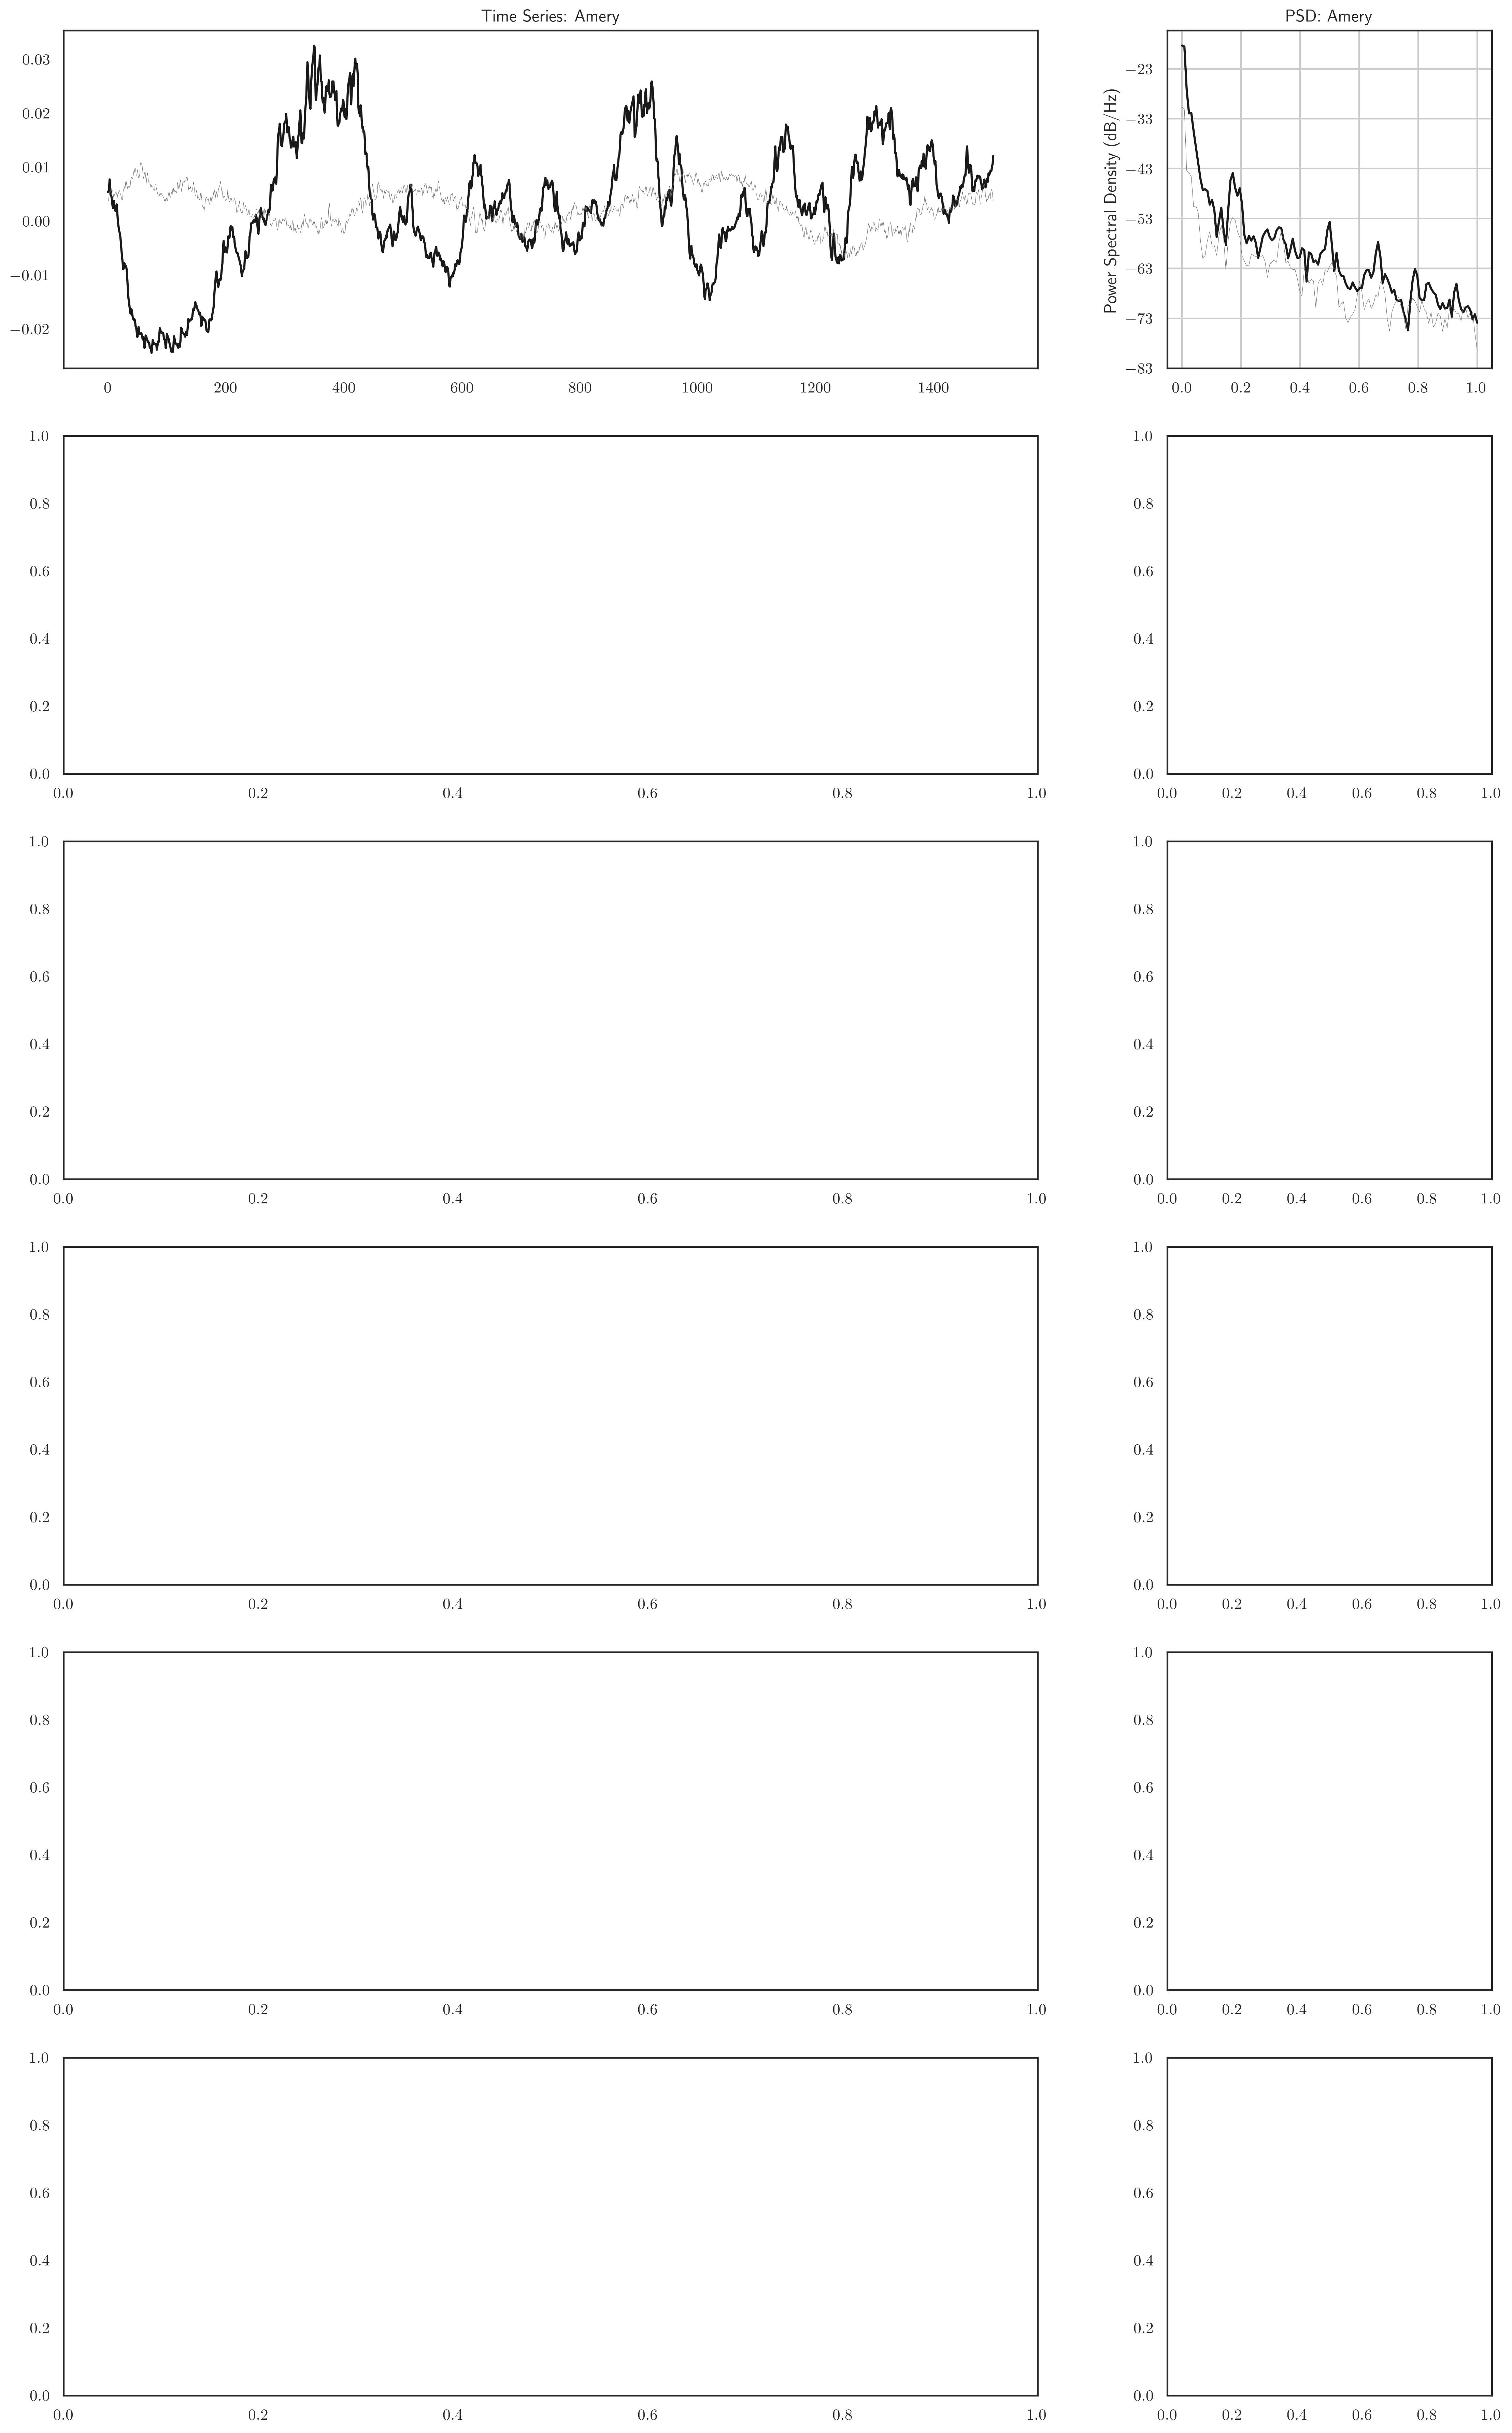

In [11]:
catchments = np.array([1,27,28,61,70,83])
#catchments = np.array([1,27,28,61])
basins = catchments+33
n_basins = len(basins)
color_orig = 'k'
color_gen = 'dimgray'

sns.set_theme(style="white")
fig=plt.figure(figsize=(18,5*n_basins))

gs = GridSpec(n_basins, 2, width_ratios=[3, 1])
ax0 = [fig.add_subplot(gs[i, 0]) for i in range(n_basins)]
ax1 = [fig.add_subplot(gs[i, 1]) for i in range(n_basins)]

for i,(a0,a1) in enumerate(zip(ax0,ax1)):
    orig = clip_data(flux_clean, basins[i])
    rec0 = clip_data(spca_a01, basins[i])
    #rec1 = clip_data(sparse_rec1, basins[i])
    #rec2 = clip_data(flux_reconstr2, basins[i])
    orig = orig.rename('orig')
    rec0 = rec0.rename('rec0')
    #rec1 = rec1.rename('rec1')
    #rec2 = rec2.rename('rec2')
    combined = xr.merge([orig,rec0])
    combined_ts = time_series(combined)
    a0.plot(combined_ts.orig,color=color_orig, linewidth=1.5,label='Original')
    a0.plot(combined_ts.rec0,color=color_gen, linewidth=0.25,label='Randomized')
    #a0.plot(combined_ts.rec1,color=color_gen, linewidth=0.25)
    #a0.plot(combined_ts.rec2,color=color_gen, linewidth=0.25)
    a1.psd(combined_ts.orig,color=color_orig, linewidth=1.5,label='Original')
    a1.psd(combined_ts.rec0,color=color_gen, linewidth=0.25,label='Randomized')
    #a1.psd(combined_ts.rec1,color=color_gen, linewidth=0.25)
    #a1.psd(combined_ts.rec2,color=color_gen, linewidth=0.25)
    a0.set_title('Time Series: {}'.format(icems.name[basins[i]]))
    a1.set_title('PSD: {}'.format(icems.name[basins[i]]))
    a0.set_xlabel('')
    a1.set_xlabel('')
    axins = inset_axes(a0, width="30%", height="30%", loc="upper right", 
                       axes_class=cartopy.mpl.geoaxes.GeoAxes, 
                       axes_kwargs=dict(projection=ccrs.SouthPolarStereo()))
    icems[33:133].plot(ax=axins,linewidth=0.3,color='lightsteelblue')
    axins.coastlines(resolution='10m',linewidth=0.25)
    icems.loc[[33+catchments[i]],'geometry'].plot(ax=axins,color='k',linewidth=0.4)
    del orig, rec0, combined
a1.legend();
a0.set_xlabel('Time (months)');
a1.set_xlabel('Frequency');
#plt.savefig(inDirName+processed_data_folder+pca_3+'generator-compare_{}-modes'.format(mode_number))
gc.collect()